In [1]:
''' There are differenct sections in this notebook:

(1) General section, where I read csv, create my functions,
    import of libraries...
    
(2) Feature engineer, where I studied and trasformed all variable 
    of dataset and

(3) Feature Selection, where I chooice with ExtraClassifierTree the best
    variables.

(4) Regression part

(5) Classification

(6) Pipeline where there is all code without comments, for a fast execute 
    of it
'''

# ---------- FEATURES ENGINEER --------

# Libraries

In [2]:
# General libraries

import pandas as pd       # for wraggler dataframe
import numpy as np        # array and other operations
import matplotlib.pyplot as plt  # some plot
from scipy.stats import stats,pearsonr,spearmanr  # correlation and qqnorm
import scipy.stats as stats
import pylab                                # plot qqnorm
import warnings                             #hide warnings
warnings.filterwarnings('ignore')


# Machine learning libraries
from sklearn.model_selection import train_test_split # split dataframe
from sklearn.model_selection import cross_val_score  # cross-validation
from sklearn import metrics                 # metrics for evaluating performance
from sklearn.model_selection import GridSearchCV     # tuning hyper-parameters
from sklearn.metrics import classification_report    # print reports
from sklearn.ensemble import ExtraTreesClassifier    # feature selection

# Regression models
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor


# Classifier models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

plt.style.use('seaborn-whitegrid')     # style plot

# User functions

In [3]:
def frequency_calc(df):   # function to calculate frequency for categorycal
    freq_rel={}           # variable    
    categ=df.unique()
    sum=0
    for ci in categ:
        try: np.isnan(ci)
        except: 
                val=len(df[df==ci])/len(df)
                freq_rel[ci]=val
                sum=sum+val                
        if sum>0:
            freq_rel['nan']=1-sum

    return freq_rel
    
    
def cat_func(row,genre):              # particular function for
    try:                              # one-hot-encoding
        if genre.upper() in row.upper():
            return 1
        else:
            return 0
    except:
        np.nan   
        
        
def toCateg(var):              # trasform numeric target variable 
    k=''                       # to categorical variable
    if (var>=1 and var<3):
        k='Flop Movie'
    
    elif (var>=3 and var<6):
        k='Average Movie'
    elif (var>=6 and var<10):
        k='Hit Movie' 
    return k


def user_outlier(df,var,k):        # function to correct outliers 
    
    q1=np.percentile(df[var].dropna(),25)
    q3=np.percentile(df[var].dropna(),75)
    dif=(q3-q1)*k
    df[var][df[var]<q1-dif]=q1
    df[var][df[var]>q3+dif]=q3
    return df[var]


def user_standardize(df,var):         # function to standardize variable
    df[var]=(df[var] -df[var].mean())/(df[var].std())
    return df[var]


# Dataframe

In [4]:
df=pd.read_csv('movie_metadata.csv') # read dataframe  

print('#cols :'+str(len(df.columns)))

print('#rows :'+str(len(df)))
print(df.head())

#cols :28
#rows :5043
   color      director_name  num_critic_for_reviews  duration  \
0  Color      James Cameron                   723.0     178.0   
1  Color     Gore Verbinski                   302.0     169.0   
2  Color         Sam Mendes                   602.0     148.0   
3  Color  Christopher Nolan                   813.0     164.0   
4    NaN        Doug Walker                     NaN       NaN   

   director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
0                      0.0                   855.0  Joel David Moore   
1                    563.0                  1000.0     Orlando Bloom   
2                      0.0                   161.0      Rory Kinnear   
3                  22000.0                 23000.0    Christian Bale   
4                    131.0                     NaN        Rob Walker   

   actor_1_facebook_likes        gross                           genres  ...  \
0                  1000.0  760505847.0  Action|Adventure|Fantasy|Sci-Fi  .

# Drop variables with 5+ Nan

In [5]:
len(df.dropna(thresh=len(df.columns) - 5))
df=df.dropna(thresh=len(df.columns) - 5)  

# Drop rows with at least 5 NaN

# Target Variable

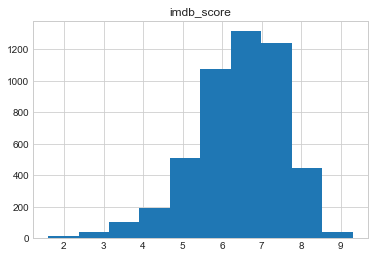

In [6]:
var='imdb_score'

df.hist(column=var)

df[var+'_cat']=df[var].apply(toCateg)     # categorical variable

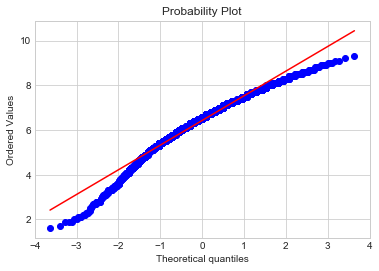

In [7]:
measurements = df[var]
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

# it is not gaussian but I decide don't trasform it
# df['imdb_score']=np.log(1+df[var])
# df[var]=(df[var] -df[var].mean())/(df[var].std())

([<matplotlib.patches.Wedge at 0x1c4ec33aa90>,
 [Text(-0.6720029188715269, 0.8708685762089181, 'Hit Movie'),
  Text(0.6497663673559881, -0.8875830484258942, 'Average Movie'),
  Text(1.0996482505788194, -0.02781591269295471, 'Flop Movie')])

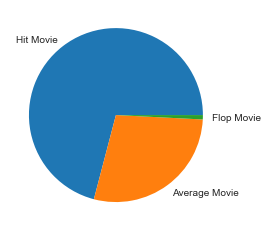

In [8]:
labels=list(filter(lambda x:x!='nan',list(frequency_calc(df[var+'_cat']).keys())))

values=list(filter(lambda x:x>0.00000001,list(frequency_calc(df[var+'_cat']).values())))

plt.pie(values,labels=labels)


# Dataframe is really unbalanced!!

# ---------- FEATURES ENGINEER --------

# Variable: color

In [9]:
frequency_calc(df['color'])
# there are few "Black and White" movies

df=df.drop('color',axis=1)

# Variable: director_name

In [10]:
df['director_name']=df.director_name.str.lower()
print(frequency_calc(df['director_name']))

# too dispersive, so I eliminate it

df=df.drop('director_name',axis=1)

{'james cameron': 0.001408734151740793, 'nan': 0.011471120949880564, 'gore verbinski': 0.001408734151740793, 'sam mendes': 0.0016099818877037633, 'christopher nolan': 0.0016099818877037633, 'andrew stanton': 0.0006037432078889113, 'sam raimi': 0.0026162205675186153, 'nathan greno': 0.0002012477359629704, 'joss whedon': 0.0008049909438518816, 'david yates': 0.0008049909438518816, 'zack snyder': 0.0016099818877037633, 'bryan singer': 0.0016099818877037633, 'marc forster': 0.0016099818877037633, 'andrew adamson': 0.001006238679814852, 'rob marshall': 0.001006238679814852, 'barry sonnenfeld': 0.001408734151740793, 'peter jackson': 0.002414972831555645, 'marc webb': 0.0006037432078889113, 'ridley scott': 0.003421211511370497, 'chris weitz': 0.001006238679814852, 'anthony russo': 0.0008049909438518816, 'peter berg': 0.0012074864157778226, 'colin trevorrow': 0.0004024954719259408, 'shane black': 0.0004024954719259408, 'tim burton': 0.0032199637754075265, 'brett ratner': 0.002012477359629704, 

# Variable: num_critic_for_reviews

0.3182488529649534


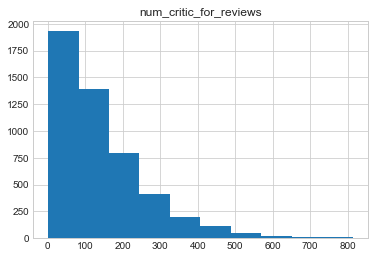

In [11]:
var='num_critic_for_reviews' #numeric

frequency_calc(df[var])
df.hist(column=var)
print(df[[var,'imdb_score']].corr().iloc[0][1])
# it is correlate with our target variable

# correct outliers and standardize it
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

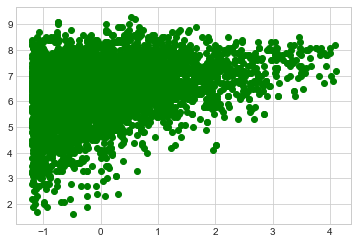

In [12]:
x = df[var]
y = df['imdb_score']

plt.plot(x, y, 'o', color='green');  # relationship

# Variable: duration

In [13]:
var='duration' #numeric

print(df[[var,'imdb_score']].corr().iloc[0][1])

# correct outlier and standardize variable
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

0.2909144218398335


# Variable: director_facebook_likes

In [14]:
var='director_facebook_likes'

print(df[[var,'imdb_score']].corr().iloc[0][1])


# correct outlier and standardize variable
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

0.17242848283859694


# Variable: actor_3_facebook_likes

In [15]:
var='actor_3_facebook_likes'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
#df[var]=user_outlier(df,var,3)
#df[var]=user_standardize(df,var)

# there isn't correlation
df=df.drop(var,axis=1)

0.05553385877601566


# Variable: actor_1_facebook_likes

In [16]:
var='actor_1_facebook_likes'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# correct outlier and standardize variable
#df[var]=user_outlier(df,var,3)
#df[var]=user_standardize(df,var)

# there isn't correlation
df=df.drop(var,axis=1)

0.07423753820531266


# Variable: gross

In [17]:
var='gross'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

# there isn't correlation
#df=df.drop(var,axis=1)

0.1985026022070261


# Variable: genres

In [18]:
# There are combination of genres.
# (1) Extract main kinds of movie from each record
# (2) Create for each main genre a new variable with value 1 if 
#     movie is of that genre else 0.

l=list(set(' '.join(list(df.genres.unique())).split('|')))      
my_list = [x for x in l if ' ' not in x]
   
for k in my_list:
    df['genre_'+k]=df['genres'].apply(cat_func,genre=k)

df=df.drop('genres',axis=1)

# this increase # of columns

# Variable: actor_x_name

In [19]:
"""
df.actor_1_name=df.actor_1_name.str.lower().str.replace(' ','')
df.actor_2_name=df.actor_2_name.str.lower().str.replace(' ','')
df.actor_3_name=df.actor_3_name.str.lower().str.replace(' ','')
df['actor']=df.actor_1_name+" "+df.actor_2_name+" "+df.actor_3_name
df['actor']
m=set(' '.join(df.actor.dropna()).split(' '))    
for k in m:
    df[k]=df['actor'].apply(genre_func,genre=k)
    if len(df[k][df[k]==1])==1:
        df=df.drop(k,axis=1)
"""

# too dispersive
df=df.drop('actor_1_name',axis=1)
df=df.drop('actor_2_name',axis=1)
df=df.drop('actor_3_name',axis=1)

# Variable: movie_title

In [20]:
var='movie_title'

# too dispersive
df=df.drop(var,axis=1)

# Variable: num_voted_users

In [21]:
var='num_voted_users'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

# there isn't correlation
#df=df.drop(var,axis=1)

0.4221547591001666


# Variable: cast_total_facebook_likes                

In [22]:
var='cast_total_facebook_likes'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
#df[var]=user_outlier(df,var,3)
#df[var]=user_standardize(df,var)

# there isn't correlation
df=df.drop(var,axis=1)

0.0858835482225205


# Variable: facenumber_in_poster

In [23]:
var='facenumber_in_poster'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
#df[var]=user_outlier(df,var,3)
#df[var]=user_standardize(df,var)

# there isn't correlation
df=df.drop(var,axis=1)

-0.06435366746242847


# Variable: plot_keywords

In [24]:
# like genres
df['plot_keywords']=df.plot_keywords.str.replace(' ','')
m=set(''.join(df.plot_keywords.dropna()).replace(' ','').split('|'))

    
for k in m:
    df['keyword_'+k]=df['plot_keywords'].apply(cat_func,genre=k)
    #if len(df['keyword_'+k][df['keyword_'+k]==1])==1:
    #   df=df.drop('keyword_'+k,axis=1)
    
df=df.drop('plot_keywords',axis=1)  

# Variable: movie_imdb_link

In [25]:
var='movie_imdb_link'
print(frequency_calc(df['movie_imdb_link']))
# useless variable, it is not informative
df=df.drop(var,axis=1)

{'http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'nan': -1.0880185641326534e-14, 'http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt0401729/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt0413300/?ref_=fn_tt_tt_1': 0.0004024954719259408, 'http://www.imdb.com/title/tt0398286/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt2395427/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt0417741/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt2975590/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt0348150/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.com/title/tt0830515/?ref_=fn_tt_tt_1': 0.0002012477359629704, 'http://www.imdb.co

# Variable: movie_facebook_likes

In [26]:
var='movie_facebook_likes'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

# there isn't correlation
#df=df.drop(var,axis=1)

0.25257985001969685


# Variable: num_user_for_reviews

In [27]:
var='num_user_for_reviews'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

# there isn't correlation
#df=df.drop(var,axis=1)

0.30051257375381674


# Variable: language

In [28]:
frequency_calc(df['language'])

{'English': 0.9341919903401087,
 'nan': 0.0016099818877035599,
 'Japanese': 0.003421211511370497,
 'French': 0.01469108472529684,
 'Mandarin': 0.0052324411350372305,
 'Aboriginal': 0.0004024954719259408,
 'Spanish': 0.008049909438518816,
 'Filipino': 0.0002012477359629704,
 'Hindi': 0.005634936606963172,
 'Russian': 0.0022137250955926746,
 'Maya': 0.0002012477359629704,
 'Kazakh': 0.0002012477359629704,
 'Telugu': 0.0002012477359629704,
 'Cantonese': 0.0022137250955926746,
 'German': 0.003823706983296438,
 'Aramaic': 0.0002012477359629704,
 'Italian': 0.002012477359629704,
 'Dutch': 0.0008049909438518816,
 'Dari': 0.0004024954719259408,
 'Hebrew': 0.0008049909438518816,
 'Chinese': 0.0006037432078889113,
 'Mongolian': 0.0002012477359629704,
 'Swedish': 0.0008049909438518816,
 'Korean': 0.0016099818877037633,
 'Thai': 0.0006037432078889113,
 'Polish': 0.0006037432078889113,
 'Bosnian': 0.0002012477359629704,
 'None': 0.0004024954719259408,
 'Hungarian': 0.0002012477359629704,
 'Portugue

# Variable: country

In [29]:
var='country'

print(frequency_calc(df[var]))

# I prefer take country instead language because probably it is more informative 
df2=pd.get_dummies(df.country)
df=pd.concat([df, df2], axis=1)
df=df.drop(var,axis=1)
df=df.drop('language',axis=1)

{'USA': 0.7576977259005836, 'nan': 0.00020124773596252865, 'UK': 0.08734151740792916, 'New Zealand': 0.0030187160394445564, 'Canada': 0.024753471523445363, 'Australia': 0.010666130006037432, 'Belgium': 0.0008049909438518816, 'Japan': 0.004427450191185349, 'Germany': 0.01952103038840813, 'China': 0.006037432078889113, 'France': 0.030992151338297445, 'New Line': 0.0002012477359629704, 'Mexico': 0.003421211511370497, 'Spain': 0.006641175286778024, 'Hong Kong': 0.003421211511370497, 'Czech Republic': 0.0006037432078889113, 'India': 0.006439927550815053, 'Soviet Union': 0.0002012477359629704, 'South Korea': 0.002817468303481586, 'Peru': 0.0002012477359629704, 'Italy': 0.004427450191185349, 'Russia': 0.0022137250955926746, 'Aruba': 0.0002012477359629704, 'Denmark': 0.0022137250955926746, 'Libya': 0.0002012477359629704, 'Ireland': 0.002414972831555645, 'South Africa': 0.0016099818877037633, 'Switzerland': 0.0006037432078889113, 'Romania': 0.0008049909438518816, 'West Germany': 0.0006037432078

# Variable: content_rating

In [30]:
var='content_rating'
    
   
print(frequency_calc(df[var]))

# take this variable, because it doesn't dispersive
df2=pd.get_dummies(df.content_rating)
df=pd.concat([df, df2], axis=1)
df=df.drop(var,axis=1)

{'PG-13': 0.2938216945059368, 'nan': 0.04850070436707565, 'PG': 0.14107466291004225, 'G': 0.022539746427852687, 'R': 0.4262427047695713, 'TV-14': 0.00503119339907426, 'TV-PG': 0.0026162205675186153, 'TV-G': 0.0018112296236667338, 'TV-MA': 0.0032199637754075265, 'Not Rated': 0.023143489635741598, 'Unrated': 0.012477359629704166, 'Approved': 0.011068625477963372, 'TV-Y': 0.0002012477359629704, 'NC-17': 0.001408734151740793, 'X': 0.0026162205675186153, 'TV-Y7': 0.0002012477359629704, 'GP': 0.0012074864157778226, 'Passed': 0.0018112296236667338, 'M': 0.001006238679814852}


# Variable: budget

In [31]:
var= 'budget'
        
print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
#df[var]=user_outlier(df,var,3)
#df[var]=user_standardize(df,var)

# there isn't correlation
df=df.drop(var,axis=1)

0.03105339147994713


# Variable: title_year

In [32]:
var='title_year'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

# there isn't correlation
#df=df.drop(var,axis=1)

-0.21267605462165168


# Variable: actor_2_facebook_likes

In [33]:
var='actor_2_facebook_likes'


print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
#df[var]=user_outlier(df,var,3)
#df[var]=user_standardize(df,var)

# there isn't correlation
df=df.drop(var,axis=1)

0.08792067950907705


# Variable: aspect_ratio

In [34]:
var='aspect_ratio'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
#df[var]=user_outlier(df,var,3)
#df[var]=user_standardize(df,var)

# there isn't correlation
df=df.drop(var,axis=1)

0.034882959695101676


# Variable: movie_facebook_likes

In [35]:
var='movie_facebook_likes'

print(df[[var,'imdb_score']].corr().iloc[0][1])

# there is correlation
# correct outlier and standardize variable
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

# there isn't correlation
#df=df.drop(var,axis=1)

0.2047965300152246


# Columns

In [36]:
print("#columns: "+str(len(df.columns)))

#columns: 10485


# ---------- FEATURES SELECTION--------

# Drop Nan

In [37]:
df=df.dropna().reset_index(drop=True)

In [38]:
df.head()

,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,num_user_for_reviews,title_year,imdb_score,movie_facebook_likes,imdb_score_cat,...,Passed,R,TV-14,TV-G,TV-MA,TV-PG,TV-Y,TV-Y7,Unrated,X
0,0.499301,3.529973,-0.745120,0.462204,0.459845,0.462235,0.568233,7.9,0.665070,Hit Movie,...,0,0,0,0,0,0,0,0,0,0
1,1.425826,3.084774,2.718879,0.462204,0.459845,0.462235,0.366450,7.1,-0.542172,Hit Movie,...,0,0,0,0,0,0,0,0,0,0
2,4.048065,2.045978,-0.745120,3.437968,2.856960,3.489839,1.173582,6.8,0.665070,Hit Movie,...,0,0,0,0,0,0,0,0,0,0
3,0.499301,2.837442,0.466972,0.462204,0.459845,0.462235,0.870907,8.5,0.665070,Hit Movie,...,0,0,0,0,0,0,0,0,0,0
4,2.824353,1.254514,2.177436,0.694171,1.999745,2.324325,0.870907,6.6,0.665070,Hit Movie,...,0,0,0,0,0,0,0,0,0,0


# Regression with crossvalidation without Tuning

In [39]:
# Regression models to choiche the best model for applying tuning and 
# features selection.

df2=df.drop('imdb_score_cat',axis=1)
X=df2.loc[:, df2.columns != 'imdb_score']
Y=df2['imdb_score']

print("LinearRegression")

regressor = LinearRegression()
scores = cross_val_score(regressor, X, Y, cv=10, scoring=metrics.make_scorer(metrics.mean_squared_error))
print("mse: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print()
print("DecisionTree")

regressor = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(regressor, X, Y, cv=10, scoring=metrics.make_scorer(metrics.mean_squared_error))
print("mse: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print()
print("SVR")

regressor = SVR(gamma='scale', C=1.0, epsilon=0.2)
scores = cross_val_score(regressor, X, Y, cv=10, scoring=metrics.make_scorer(metrics.mean_squared_error))
print("mse: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print()
print("AdaBoosting")
regressor = AdaBoostRegressor(random_state=0, n_estimators=100)
scores = cross_val_score(regressor, X, Y, cv=10, scoring=metrics.make_scorer(metrics.mean_squared_error))
print("mse: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print()
print("RandomForest")

regressor = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
scores = cross_val_score(regressor, X, Y, cv=10, scoring=metrics.make_scorer(metrics.mean_squared_error))
print("mse: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



LinearRegression
mse: 9.62 (+/- 4.24)

DecisionTree
mse: 0.69 (+/- 0.30)

SVR
mse: 0.52 (+/- 0.22)
mse: 0.81 (+/- 0.51)

RandomForest
mse: 0.79 (+/- 0.34)


# Feature importances 

[0.01828699 0.02421388 0.01217282 ... 0.         0.00039626 0.00014111]


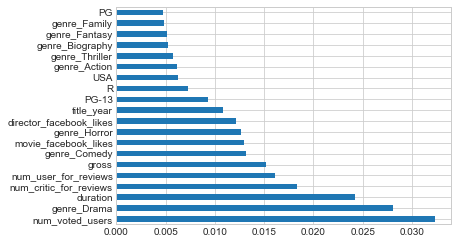

In [40]:
# For features selection I used class 
# feature_importances of tree based classifiers

df2=df.drop('imdb_score',axis=1)
X=df2.loc[:, df2.columns != 'imdb_score_cat']
Y=df2['imdb_score_cat']


model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) 
# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [41]:
k=feat_importances.nlargest(10000)
k[0:10]

num_voted_users            0.032366
genre_Drama                0.028064
duration                   0.024214
num_critic_for_reviews     0.018287
num_user_for_reviews       0.016107
gross                      0.015205
genre_Comedy               0.013151
movie_facebook_likes       0.012948
genre_Horror               0.012654
director_facebook_likes    0.012173
dtype: float64

In [42]:
# choice the best set of variables 
# (I used SVR because I saw it is the  best model )

for i in [0.0005,0.001,0.002,0.003,0.005,0.0075,0.01,0.025,0.05,0.075,0.1]:
    print(str(i))
    X=df2[list(k[k>i].index)]
    Y=df['imdb_score']


    regressor = SVR(gamma='scale', C=1.0, epsilon=0.2).fit(X,Y)
    scores = cross_val_score(regressor, X, Y, cv=10, scoring=metrics.make_scorer(metrics.mean_squared_error))
    print("mse: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.0005
mse: 0.51 (+/- 0.21)
0.001
mse: 0.50 (+/- 0.20)
0.002
mse: 0.50 (+/- 0.20)
0.003
mse: 0.50 (+/- 0.20)
0.005
mse: 0.54 (+/- 0.24)
0.0075
mse: 0.58 (+/- 0.24)
0.01
mse: 0.59 (+/- 0.24)
0.025
mse: 0.81 (+/- 0.33)
0.05


ValueError: Found array with 0 feature(s) (shape=(4110, 0)) while a minimum of 1 is required.

In [43]:
# df2 will be df after feature selection

df2=df.drop('imdb_score',axis=1)
X=df2[list(k[k>0.0025].index)]
Y=df['imdb_score']

print("#cols :"+str(len(X.columns)))
print(X.columns)

#cols :37
Index(['num_voted_users', 'genre_Drama', 'duration', 'num_critic_for_reviews',
       'num_user_for_reviews', 'gross', 'genre_Comedy', 'movie_facebook_likes',
       'genre_Horror', 'director_facebook_likes', 'title_year', 'PG-13', 'R',
       'USA', 'genre_Action', 'genre_Thriller', 'genre_Biography',
       'genre_Fantasy', 'genre_Family', 'PG', 'genre_Romance',
       'keyword_criticallybashed', 'genre_Adventure', 'genre_Mystery', 'UK',
       'genre_Crime', 'genre_Animation', 'genre_History', 'genre_Sci-Fi',
       'genre_Documentary', 'keyword_art', 'keyword_box', 'keyword_ship',
       'keyword_murder', 'keyword_friend', 'keyword_office', 'genre_Music'],
      dtype='object')


# ---------- REGRESSION--------

# Tuning HyperParameters 

In [44]:
#
# (1) Split dataset to train_set  (for training model) and test_set (for testing
#     model
# (2) SVR is the best model, so I tuning just it

X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.33, random_state=42)

In [45]:
# Gridsearch on these parameters

tuned_parameters = [
  {'kernel': ['linear', 'rbf', 'sigmoid'],
  'gamma': [0.1,0.2,0.3,0.4],
   'C': [0.3, 0.6,1,1.5,2],
   'shrinking':[True,False]}
 ]

In [47]:
score = ['RMSE']

print("# Tuning hyper-parameters for %s" % score)
print()

regression = GridSearchCV(SVR(), tuned_parameters, cv=5)
regression.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(regression.best_params_)
print()
print("Grid scores on development set:")
print()
means = regression.cv_results_['mean_test_score']
stds = regression.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, regression.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, regression.predict(X_test)
print(classification_report(y_true, y_pred))
print()



# Tuning hyper-parameters for ['RMSE']

Best parameters set found on development set:

{'C': 2, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}

Grid scores on development set:

0.428 (+/-0.042) for {'C': 0.3, 'gamma': 0.1, 'kernel': 'linear', 'shrinking': True}
0.428 (+/-0.042) for {'C': 0.3, 'gamma': 0.1, 'kernel': 'linear', 'shrinking': False}
0.499 (+/-0.031) for {'C': 0.3, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}
0.499 (+/-0.031) for {'C': 0.3, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': False}
-93.115 (+/-23.005) for {'C': 0.3, 'gamma': 0.1, 'kernel': 'sigmoid', 'shrinking': True}
-93.310 (+/-23.281) for {'C': 0.3, 'gamma': 0.1, 'kernel': 'sigmoid', 'shrinking': False}
0.428 (+/-0.042) for {'C': 0.3, 'gamma': 0.2, 'kernel': 'linear', 'shrinking': True}
0.428 (+/-0.042) for {'C': 0.3, 'gamma': 0.2, 'kernel': 'linear', 'shrinking': False}
0.471 (+/-0.025) for {'C': 0.3, 'gamma': 0.2, 'kernel': 'rbf', 'shrinking': True}
0.471 (+/-0.025) for {'C': 0.3, 'gamma': 0.2, 'kerne

ValueError: continuous is not supported

# Regression with the best model

In [48]:
# The best model
df2=df.drop('imdb_score',axis=1)
X=df2[list(k[k>0.0025].index)]
Y=df['imdb_score']


regressor = SVR(C= 1, gamma= 0.1, kernel= 'rbf', shrinking= True).fit(X, Y)
scores = cross_val_score(regressor, X, Y, cv=10, scoring=metrics.make_scorer(metrics.mean_squared_error))
print("mse: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


mse: 0.49 (+/- 0.20)


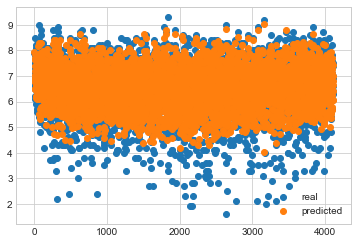

In [49]:
plt.scatter(range(0,len(df)),df['imdb_score'],label='real')
plt.scatter(range(0,len(df)),regressor.predict(X),label='predicted')
plt.legend()

# we can see that model misses records with value<4.

# ---------- CLASSIFICATION--------

# Classification problem

In [50]:
frequency_calc(df['imdb_score_cat'])

# The previous regression model wrongs value <4 
# because dataset is unbalanced.
# We can use more tecnhiques to adjust it, for example SMOTE or 
# OVER / UNDER SAMPLING

# Also, we have to use a metric for sbalanced
# dataset, I will use f1_macro.

{'Hit Movie': 0.7265206812652069,
 'nan': 0.0,
 'Average Movie': 0.26739659367396595,
 'Flop Movie': 0.006082725060827251}

# Classifier with Unbalanced Dataset

In [51]:
# Try with Unbalanced Dataset with no technique for balancing it

j=list(k[k>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)


In [52]:
df3=df2.drop('imdb_score_cat',axis=1)
X=df3
Y=df2['imdb_score_cat']

print('DecisionTree')

classifier=  DecisionTreeClassifier(random_state=0).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')
print("f1_macro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()
print('RandomForest')

classifier =  RandomForestClassifier(n_estimators=100,random_state=0).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')
print("f1_macro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print()
print('KNN')

classifier =  KNeighborsClassifier(n_neighbors=3).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')
print("f1_macro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()
print("GaussianNB")

classifier =  GaussianNB().fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')
print("f1_macro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

DecisionTree
f1_macro: 0.47 (+/- 0.10)

RandomForest
f1_macro: 0.50 (+/- 0.08)

KNN
f1_macro: 0.51 (+/- 0.15)

GaussianNB
f1_macro: 0.29 (+/- 0.07)


# OverSampling and UnderSampling Classifier

In [53]:
# Try with oversampling 4x times the least frequent class
# and undersampling (from 2817 to 1750 roes) the most frequent class

j=list(k[k>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

# OverSampling
df2=pd.concat([dfx1, dfx2], axis=1)
df3=df2[df2['imdb_score_cat']=='Flop Movie']
df2=pd.concat([df3,df2])
df2=pd.concat([df3,df2])
df2=pd.concat([df3,df2])

# UnderSampling
df3=df2[df2['imdb_score_cat']=='Hit Movie'].sample(1750)
df2=df2[df2['imdb_score_cat']!='Hit Movie']

df2=pd.concat([df3,df2])

frequency_calc(df2['imdb_score_cat'])

{'Hit Movie': 0.593421498813157,
 'nan': 0.0,
 'Flop Movie': 0.0339097999321804,
 'Average Movie': 0.3726687012546626}

In [54]:
df3=df2.drop('imdb_score_cat',axis=1)
X=df3
Y=df2['imdb_score_cat']

print('DecisionTree')

classifier=  DecisionTreeClassifier(random_state=0).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')
print("f1_macro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()
print('RandomForest')

classifier =  RandomForestClassifier(n_estimators=100,random_state=0).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')
print("f1_macro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print()
print('KNN')

classifier =  KNeighborsClassifier(n_neighbors=3).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')
print("f1_macro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()
print("GaussianNB")

classifier =  GaussianNB().fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=10, scoring='f1_macro')
print("f1_macro: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

DecisionTree
f1_macro: 0.76 (+/- 0.06)

RandomForest
f1_macro: 0.85 (+/- 0.09)

KNN
f1_macro: 0.75 (+/- 0.06)

GaussianNB
f1_macro: 0.31 (+/- 0.05)


# Classification with the best model on full dataset

In [55]:
# We trained model with dataset with over and undersampling and now we test
# it on the full dataset

classifier =  RandomForestClassifier(n_estimators=100,random_state=0).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=20, scoring='f1_macro')

In [56]:
j=list(k[k>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)
j=list(k[k>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)

df3=df2.drop('imdb_score_cat',axis=1)
X=df3
Y=df2['imdb_score_cat']

print()
print('f1_macro')
print(metrics.f1_score(Y, classifier.predict(X), average='macro'))
print()
print('confusion_matrix')

# confusion matrix
pd.DataFrame(metrics.confusion_matrix(Y, classifier.predict(X)),
            columns=['Flop Movie real','Average Movie real','Hit Movie real'],index=['Flop Movie pred','Avg Movie pred','Hit Movie pred'])



# model is very good, so I don't need SMOTE technique, tuning parameters
# or look for another model. 


f1_macro
0.96497670405522

confusion_matrix


,Flop Movie real,Average Movie real,Hit Movie real
Flop Movie pred,1099,0,0
Avg Movie pred,0,25,0
Hit Movie pred,177,0,2809


# ---------- PIPELINE--------

# PIPELINE

In [57]:
# This part of code contains all code without comments. But it is very fast.

In [65]:
# General libraries

df=pd.read_csv('movie_metadata.csv') # read dataframe

import pandas as pd       # for wraggler dataframe
import numpy as np        # array and other operations
import matplotlib.pyplot as plt  # some plot
from scipy.stats import stats,pearsonr,spearmanr  # correlation and qqnorm
import pylab                                # plot qqnorm
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split # split dataframe
from sklearn.model_selection import cross_val_score  # cross-validation
from sklearn import metrics                 # metrics for evaluating performance
from sklearn.model_selection import GridSearchCV     # tuning hyper-parameters
from sklearn.metrics import classification_report    # print reports
from sklearn.ensemble import ExtraTreesClassifier    # feature selection

# Regression models
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor


# Classifier models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

plt.style.use('seaborn-whitegrid')     # style plot

def frequency_calc(df):   # function to calculate frequency for categorycal
    freq_rel={}           # variable    
    categ=df.unique()
    sum=0
    for ci in categ:
        try: np.isnan(ci)
        except: 
                val=len(df[df==ci])/len(df)
                freq_rel[ci]=val
                sum=sum+val                
        if sum>0:
            freq_rel['nan']=1-sum

    return freq_rel
    
    
def cat_func(row,genre):              # particular function for
    try:                              # one-hot-encoding
        if genre.upper() in row.upper():
            return 1
        else:
            return 0
    except:
        np.nan   
        
        
def toCateg(var):              # trasform numeric target variable 
    k=''                       # to categorical variable
    if (var>=1 and var<3):
        k='Flop Movie'
    
    elif (var>=3 and var<6):
        k='Average Movie'
    elif (var>=6 and var<10):
        k='Hit Movie' 
    return k


def user_outlier(df,var,k):        # function to correct outliers 
    
    q1=np.percentile(df[var].dropna(),25)
    q3=np.percentile(df[var].dropna(),75)
    dif=(q3-q1)*k
    df[var][df[var]<q1-dif]=q1
    df[var][df[var]>q3+dif]=q3
    return df[var]


def user_standardize(df,var):         # function to standardize variable
    df[var]=(df[var] -df[var].mean())/(df[var].std())
    return df[var]




df=df.dropna(thresh=len(df.columns) - 5)  
var='imdb_score'
df['imdb_score_cat']=df[var].apply(toCateg)
df=df.drop('color',axis=1)
df=df.drop('director_name',axis=1)
var='num_critic_for_reviews'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)
var='duration'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)
var='director_facebook_likes'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)
df=df.drop('actor_3_facebook_likes',axis=1)
df=df.drop('actor_2_facebook_likes',axis=1)
df=df.drop('actor_1_facebook_likes',axis=1)
var='gross'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

l=list(set(' '.join(list(df.genres.unique())).split('|')))      
my_list = [x for x in l if ' ' not in x]
   
for k in my_list:
    df['genre_'+k]=df['genres'].apply(cat_func,genre=k)

df=df.drop('genres',axis=1)

df=df.drop('actor_1_name',axis=1)
df=df.drop('actor_2_name',axis=1)
df=df.drop('actor_3_name',axis=1)


df=df.drop('movie_title',axis=1)

var='num_voted_users'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)


df=df.drop('cast_total_facebook_likes',axis=1)

df=df.drop('facenumber_in_poster',axis=1)


# like genres
df['plot_keywords']=df.plot_keywords.str.replace(' ','')
m=set(''.join(df.plot_keywords.dropna()).replace(' ','').split('|'))

    
for k in m:
    df['keyword_'+k]=df['plot_keywords'].apply(cat_func,genre=k)
    
df=df.drop('plot_keywords',axis=1) 

df=df.drop('movie_imdb_link',axis=1)

var='movie_facebook_likes'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

var='num_user_for_reviews'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

var='country'
df2=pd.get_dummies(df.country)
df=pd.concat([df, df2], axis=1)
df=df.drop(var,axis=1)
df=df.drop('language',axis=1)

var='content_rating'
df2=pd.get_dummies(df.content_rating)
df=pd.concat([df, df2], axis=1)
df=df.drop(var,axis=1)

df=df.drop('budget',axis=1)


var='title_year'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

df=df.drop('aspect_ratio',axis=1)

var='movie_facebook_likes'
df[var]=user_outlier(df,var,3)
df[var]=user_standardize(df,var)

df=df.dropna().reset_index(drop=True)

# For features selection I used class 
# feature_importances of tree based classifiers

df2=df.drop('imdb_score',axis=1)
X=df2.loc[:, df2.columns != 'imdb_score_cat']
Y=df2['imdb_score_cat']

model = ExtraTreesClassifier()
model.fit(X,Y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
t=feat_importances.nlargest(10000)

# The best model
df2=df.drop('imdb_score',axis=1)
X=df2[list(t[t>0.0025].index)]
Y=df['imdb_score']

print("REGRESSION")
regressor = SVR(C= 1, gamma= 0.1, kernel= 'rbf', shrinking= True).fit(X, Y)
scores = cross_val_score(regressor, X, Y, cv=10, scoring=metrics.make_scorer(metrics.mean_squared_error))
print("mse: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


j=list(t[t>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)
df3=df2[df2['imdb_score_cat']=='Flop Movie']
df2=pd.concat([df3,df2])
df2=pd.concat([df3,df2])
df2=pd.concat([df3,df2])
df3=df2[df2['imdb_score_cat']=='Hit Movie'].sample(1750)
df2=df2[df2['imdb_score_cat']!='Hit Movie']

df2=pd.concat([df3,df2])

frequency_calc(df2['imdb_score_cat'])

df3=df2.drop('imdb_score_cat',axis=1)
X=df3
Y=df2['imdb_score_cat']



classifier =  RandomForestClassifier(n_estimators=100,random_state=0).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=20, scoring='f1_macro')


j=list(t[t>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)
j=list(t[t>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)

df3=df2.drop('imdb_score_cat',axis=1)
X=df3
Y=df2['imdb_score_cat']
print("CLASSIFICATION")
print()
print('f1_macro')
print(metrics.f1_score(Y, classifier.predict(X), average='macro'))
print()
print('confusion_matrix')

# confusion matrix
pd.DataFrame(metrics.confusion_matrix(Y, classifier.predict(X)),
            columns=['Flop Movie real','Average Movie real','Hit Movie real'],index=['Flop Movie pred','Avg Movie pred','Hit Movie pred'])



j=list(t[t>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)
df3=df2[df2['imdb_score_cat']=='Flop Movie']
df2=pd.concat([df3,df2])
df2=pd.concat([df3,df2])
df2=pd.concat([df3,df2])
df3=df2[df2['imdb_score_cat']=='Hit Movie'].sample(1750)
df2=df2[df2['imdb_score_cat']!='Hit Movie']

df2=pd.concat([df3,df2])

frequency_calc(df2['imdb_score_cat'])

df3=df2.drop('imdb_score_cat',axis=1)
X=df3
Y=df2['imdb_score_cat']



classifier =  RandomForestClassifier(n_estimators=100,random_state=0).fit(X, Y)
scores = cross_val_score(classifier, X, Y, cv=20, scoring='f1_macro')


j=list(t[t>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)
j=list(t[t>0.0025].index)

dfx1=df[j]
dfx2=df['imdb_score_cat']

df2=pd.concat([dfx1, dfx2], axis=1)

df3=df2.drop('imdb_score_cat',axis=1)
X=df3
Y=df2['imdb_score_cat']
print("CLASSIFICATION")
print()
print('f1_macro')
print(metrics.f1_score(Y, classifier.predict(X), average='macro'))
print()
print('confusion_matrix')

# confusion matrix
pd.DataFrame(metrics.confusion_matrix(Y, classifier.predict(X)),
            columns=['Average Movie real','Flop Movie real','Hit Movie real'],index=['Average Movie pred','Flop Movie pred','Hit Movie pred'])





REGRESSION
mse: 0.50 (+/- 0.19)
CLASSIFICATION

f1_macro
0.9678243239301031

confusion_matrix
CLASSIFICATION

f1_macro
0.9674434670778292

confusion_matrix


,Average Movie real,Flop Movie real,Hit Movie real
Average Movie pred,1099,0,0
Flop Movie pred,0,25,0
Hit Movie pred,164,0,2822


# Predict on full dataset

In [ ]:
# For last, I read the full dataset, I fill nan with the mode for each variable
# and I used my models to predict on full dataset (5044 rows).
# I save results on ML_cl.csv (classification, with accuracy 89%) and
# ML_reg(regression, with mse 0.7). Instead, if I drop rows with NaN like
# this notebook, I can obtain a mse of 0.49 and an accuracy of 0.96
# ((4110-164)/4110) and f1_score of 0.967. Probably, I will improve 
# the Regression model with Over / UnderSampling or Smote technique like 
# as I did with the Classification.